# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, classification_report
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity



pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]



In [6]:
for pair in word_pairs:
    print(glove_wiki_vectors.similarity(pair[0],pair[1]))

0.70002717
0.54627603
0.6432488
0.7552733
0.8798075
0.076719455


2. Yes, the similarites betweens these words seem to have been reasonably capture by the word embeddings from GloVe Wiki vectors. For example, dog and cat are relatively similar and thus have a higher similarity score than tree and lawyer.  <br><br>

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

1. Biased models that reinforce stereotypes that are harmful to the reference group risk spreading and strengthening the idea in culture, especially when models are used at massive scales which is what the current trend of usage suggests. 

In [7]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.similarity("white", "rich")

0.44723597

In [9]:
glove_wiki_vectors.similarity("black", "rich")

0.51745194

In [10]:
analogy("white", "rich", "black")

white : rich :: black : ?


,Analogy word,Score
0,diverse,0.604348
1,especially,0.601948
2,vast,0.592111
3,wealthy,0.589454
4,impoverished,0.570855
5,richer,0.567632
6,particularly,0.566272
7,richest,0.560885
8,wealth,0.542811
9,young,0.539785


In [11]:
analogy("black", "rich", "white")

black : rich :: white : ?


,Analogy word,Score
0,rice,0.560745
1,generous,0.551037
2,brown,0.550378
3,wealthy,0.546694
4,good,0.538713
5,especially,0.533198
6,bush,0.527189
7,richer,0.523803
8,very,0.514257
9,mineral,0.513737


In [12]:
analogy("men", "dangerous", "women")

men : dangerous :: women : ?


,Analogy word,Score
0,vulnerable,0.695784
1,harmful,0.693762
2,potentially,0.682841
3,difficult,0.676691
4,especially,0.673356
5,serious,0.655973
6,particularly,0.653547
7,consequences,0.644256
8,problematic,0.633929
9,destructive,0.632473


3. As shown by the analogy function above, with particular prompts, the existing word embeddings can reinforce stereotypes. For example, analogy words such as impoverished are present when creating words for "black" from "white", but not vice versa. Similarly, Gender stereotypes are reinforced by the model as shown from the analogy words associated with women, when give the analogy men:dangerous. <br><br>

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

1. The vocabulary will not contain ALL possible words in the English language as some words may not appear on wikipedia. This is why cpsc330 would be a word not in the vocabulary as there should be no mention of cpsc330 on the wikipedia website. What would happen for unknown words then?

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [13]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [14]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [15]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [16]:
import spacy

nlp = spacy.load("en_core_web_md")

In [17]:
lr = LogisticRegression(max_iter=1000)
vec = CountVectorizer(stop_words="english")

pipe_bow = make_pipeline(vec, lr)

pipe_bow.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [18]:
print(
    classification_report(
        y_test, pipe_bow.predict(X_test), target_names=[
            "affection", "exercise", "bonding", "nature", "leisure", "achievement", "enjoy_the_moment"
        ]
    )
)

                  precision    recall  f1-score   support

       affection       0.79      0.87      0.83      1302
        exercise       0.90      0.91      0.91      1423
         bonding       0.91      0.85      0.88       492
          nature       0.60      0.54      0.57       469
         leisure       0.91      0.57      0.70        74
     achievement       0.73      0.70      0.71       407
enjoy_the_moment       0.73      0.46      0.57        71

        accuracy                           0.82      4238
       macro avg       0.80      0.70      0.74      4238
    weighted avg       0.82      0.82      0.81      4238



In [19]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])

In [20]:
lr_spacy = LogisticRegression(max_iter=4000)
lr_spacy.fit(X_train_embeddings, y_train)

/Users/seannwang/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=4000)

In [21]:
print(
    classification_report(
        y_test, lr_spacy.predict(X_test_embeddings), target_names=[
            "affection", "exercise", "bonding", "nature", "leisure", "achievement", "enjoy_the_moment"
        ]
    )
)

                  precision    recall  f1-score   support

       affection       0.81      0.83      0.82      1302
        exercise       0.86      0.91      0.89      1423
         bonding       0.83      0.77      0.80       492
          nature       0.56      0.51      0.54       469
         leisure       0.68      0.76      0.72        74
     achievement       0.72      0.65      0.68       407
enjoy_the_moment       0.69      0.72      0.70        71

        accuracy                           0.79      4238
       macro avg       0.74      0.74      0.74      4238
    weighted avg       0.79      0.79      0.79      4238



<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [22]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [23]:
df.shape

(18249, 13)

In [24]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [25]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [26]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [27]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

It seems that we have multiple measurements for the date of each avocado price. Both year and calendar date are contained in the data set as separate features.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [28]:
df.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

There are overlapping regions. For example, both California and LosAngeles exist as classes for region but in reality, LosAngeles is contained within California and is thus an overlapping region. <br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [29]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [30]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [31]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [32]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [33]:
X_train = train_df.drop(columns=["AveragePriceNextWeek" ])
y_train = train_df["AveragePriceNextWeek" ]

X_test = test_df.drop(columns=["AveragePriceNextWeek" ])
y_test = test_df["AveragePriceNextWeek" ]

In [34]:
r2_score(y_train, X_train["AveragePrice"])

0.8285800937261841

<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.



1. Many real world situations will involve unequally spaced time series data. This could include data associated with frequency of natural disasters (earthquakes/volcanos), irregular measurement of medical patient data, or irregular uploading of data from devices to conserve efficiency. 
2. Using lagged versions of features involves the usage of the auto-correlation function which allows time series data to have temporal dependence. With irregular time series data, this ACF in lag features would allow more information and complexity to be learned which would increase the predictive power of the model. Encoding the date as one or more features does not allows this temporal dependence an thus models using this technique would likely have less information and worse performance than the lagged feature models. 

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

1. In reality, simply labeling customers using a binary category can leave out some key information that may be useful for other predictions. That is why determining things like "time until churn" may be more useful than simply labeling customers as "churned" or "not churned". 

2. Generally, from lecture we could determine that the predicted survival probability decreased as more time was spent with the service. This would mean that we would predict that customer B, with a year in service, would have a lower survival probability than customer A, and would be more likely to churn. Although, in reality churning may have many more factors than time with service so we also many not have enough info to answer. 

3. This means that after a certain period, the customer will have a constant predicted survival probability after a certain amount of time of being with the service. 


<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

BLOG FOR HW3

Homework 3 was intended to give practice on data preprocessing and begin learning a ML pipeline on a real world dataset. In leymans terms, we are learning to apply the ML workflow using real adult census data to predict whether a particular adult's income exceeds 50k. The intricacies of this task lie particularly with selecting the best performing model, as well as performing data exploration that is reasonably interpretable.  

The crucial first step of any ML based solution is a thorough analysis of the data and problem. In this situation, we are predicting between two classes of incomes either >50k or <=50k. This is a classification problem where we predict between two categories, and not a regression problem where we want to predict a continuous value. This will be an important factor when we decide on the model. (Caveat)The dataset is an adult income census dataset acquired from kaggle. This contains information about 15 features for 19536 adults. The features are a mix of categorical and numerical, encoding information such as occupation, age, sex, race, education, marital status, capital gain/loss, and whether or not they earn over a 50k income. 


<br><br>


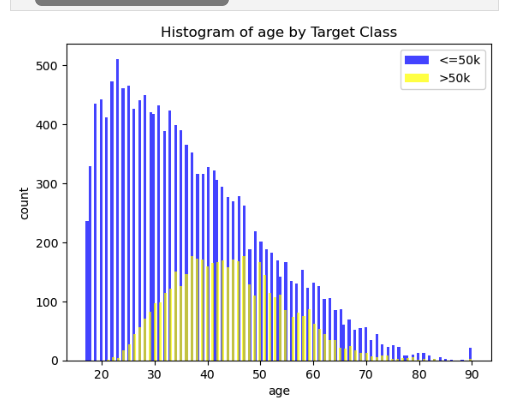


<br><br>

For example, here is a visualization of the distribution of age values with target class separated by color. From this, we can see that the largest distribution of >50k earners are between the ages of 35 to 55, while most of the <=50k earners are less than 40. From this visualization, one can see how we and a model may want to interpret a feature like age for this particular dataset.

After creating a preprocessor to perform the required corresponding data transformations for each feature, we need to determine which model to use for our prediction problem. As stated before, this problem requires classification between two categories. We can use this to determine that a DummyClassifier() should be used as a baseline model. Against this baseline, we will be evaluating the performance of a DecisionTreeClassifier(DTC), a KNeighbourClassifier(), and a RBF SupportVectorMachineClassifier (SVC). Performing cross validation to evaluate the models, we see that the SVC model has the highest test score, with KNN and DTC following in order. All three models perform better than our baseline.


<br><br>




<br><br>

From this visualization, you can see that although the DecisionTree model is performing well, it is grossly overfitting to the training data. This will lead to learning some irrelevant patterns in the feature set that will not increase the predictive power of the model on the test set. 

Since we have determined the best model to use is SVC, we must now tune its hyperparameters to optimize its performance. For RBF SVM classifiers, the C hyperparameter is tuned by training separate models corresponding to C values of 100, 10, 0.1 and 0.01. Through cross validation on the training set, we observe that the SVC RBF classifier with C value of 0.1 performs the best out of the four models. To evaluate our chosen model, we will report the results of the model on the test set. Using accuracy as our evaluation metric, the chosen model performs slightly worse than the default RBF SVM C value of 1. 

There are issues with the methodology of this assignment that may have prevented us from obtaining the true best performing model. For instance, the hyperparameter optimization was performed in a pseudo grid search like approach. Issues with Grid Search optimization is that the value obtained from the parameter space may not actually be the global optimal value. Instead, approaches such as Bayesian optimization would allow a hyperparameter tuning that would more likely lead to obtaining a global optimal value, which would in turn lead to better model performance. Furthermore, more descriptive features in the dataset would lead to a more accurate performing model. For example, features that have more information about an adult’s financial situation, such as expenses by class, or asset portfolio size could be vital information for a model intending to predict income classification. By this same notion, feature selection would potentially allow for a more efficient model. For example, since some of the features may have little weight on the predictive result, simply removing these features would result in a model that performs similarly using less data, which saves efficiency and the overall cost of running the model. In addition, the inclusion of features such as race and gender may be informatic, however they could stand to reinforce problematic biases and stereotypes. In this regard, perhaps obtaining datasets with more relevant features would prevent these ethical and communication issues. 



<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences



I am particularly satisfied with the caveat section at the end as the issues I discovered are all issues that have been discussed and worked through during my time in CPSC 330. For instance, solutions to guided hyperparameter optimization approaches such as Bayesian Optimization would have not been my instinct in solving this issue however through learning in class, I have been able to apply this knowledge to finding creative solutions to optimizing my ML models. 

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

My biggest take away from this course is how similar the approach to optimizing a model's learning is so similar to the way humans optimize their own. I guess this is an expected byproduct as we invented these models, however, it is amazing to see how conventional approaches to learning can by applied to creating customized predictive models. With a background in neuroscience, I am excited to see how potential inspiration can be taken from our own brain architecture and applied to help create better performing and more generalizable models. I would particularly look into research areas such as ensemble modeling for robots for interest into the hierarchical control scheme for more complex ensemble models, as well as real time decoding of brain imaging for commercial and medical applications. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

In [35]:
from IPython.display import Image

Image("eva-congrats.png")

FileNotFoundError: No such file or directory: 'eva-congrats.png'

FileNotFoundError: No such file or directory: 'eva-congrats.png'

<IPython.core.display.Image object>